# Setting up the plot

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Spark ML

In this lab, we will identify malign/benign brest cancers

First, you need to download the dataset at the url: http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
and initialize Spark

In [2]:
import findspark
findspark.init()

import pyspark
sc = pyspark.SparkContext(appName="Breast Cancer")

# Load the data into a Dataframe

In [3]:
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.ml.linalg import VectorUDT,Vectors

def toFloat(x):
    if x == '?':
        return 5.0
    else:
        return float(x)

def doLine(l):
    item=l.split(",")
    label = 1
    if item[10]=='2':
        label=0
    return (Vectors.dense([toFloat(e) for e in item[1:10]]),label)
    
raw_data = sc.textFile("/home/jachiet/Downloads/breast-cancer-wisconsin.data")
schema = StructType([StructField("features", VectorUDT(), True),StructField("label",IntegerType(),True)])
data = SQLContext(sc).createDataFrame(raw_data.map(doLine),schema)
data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[5.0,1.0,1.0,1.0,...|    0|
|[5.0,4.0,4.0,5.0,...|    0|
|[3.0,1.0,1.0,1.0,...|    0|
|[6.0,8.0,8.0,1.0,...|    0|
|[4.0,1.0,1.0,3.0,...|    0|
|[8.0,10.0,10.0,8....|    1|
|[1.0,1.0,1.0,1.0,...|    0|
|[2.0,1.0,2.0,1.0,...|    0|
|[2.0,1.0,1.0,1.0,...|    0|
|[4.0,2.0,1.0,1.0,...|    0|
|[1.0,1.0,1.0,1.0,...|    0|
|[2.0,1.0,1.0,1.0,...|    0|
|[5.0,3.0,3.0,3.0,...|    1|
|[1.0,1.0,1.0,1.0,...|    0|
|[8.0,7.0,5.0,10.0...|    1|
|[7.0,4.0,6.0,4.0,...|    1|
|[4.0,1.0,1.0,1.0,...|    0|
|[4.0,1.0,1.0,1.0,...|    0|
|[10.0,7.0,7.0,6.0...|    1|
|[6.0,1.0,1.0,1.0,...|    0|
+--------------------+-----+
only showing top 20 rows



# Split into training and testing

In [4]:
train, test = data.randomSplit([0.9, 0.1], seed=12345)

test.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,1.0,1.0,1.0,...|    0|
|[1.0,1.0,1.0,1.0,...|    0|
|[1.0,1.0,1.0,1.0,...|    0|
|[1.0,1.0,2.0,1.0,...|    0|
|[1.0,2.0,2.0,1.0,...|    0|
+--------------------+-----+
only showing top 5 rows



# Train a first model

In [5]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

decisionTree = DecisionTreeClassifier(maxDepth=2,labelCol="label", featuresCol="features")
model = decisionTree.fit(train)


In [6]:
predictions = model.transform(test)
predictions.filter("label=prediction").count()/predictions.count()

0.9333333333333333

# Evaluate the model

In [7]:
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label",metricName='areaUnderROC')



In [8]:
print(evaluator.evaluate(predictions))


0.9711111111111111


# Show trained model

In [9]:
print(model.toDebugString)
print(model._java_obj.getMaxDepth())

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_6a0068338f00) of depth 2 with 7 nodes
  If (feature 1 <= 2.5)
   If (feature 5 <= 5.5)
    Predict: 0.0
   Else (feature 5 > 5.5)
    Predict: 1.0
  Else (feature 1 > 2.5)
   If (feature 1 <= 3.5)
    Predict: 0.0
   Else (feature 1 > 3.5)
    Predict: 1.0

2


# Plot the ROC curve

In [10]:
def get_curve(predictions):
    points = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))).collect()
    # points should be array containing on the first column 
    # the probability of being a 1 and in the second column
    # the label.
    points.sort()# sorts the points on the probability
    
    # First we compute the total number of True and False
    nbFalse = 0.
    nbTrue = 0.
    for i in points:
        nbFalse += i[1]
        nbTrue += 1-i[1]
    
    # We now use a sliding window algorithm to compute the ROC points
    # At the beggining we have seen 0 False, 0 True
    false_positive = 0
    true_positive = 0
    fpr=[0]
    tpr=[0]
    last_proba = -1 # we want one point for each possible threshold
    for (proba,label) in points:
        false_positive += label
        true_positive += 1-label
        if last_proba == proba: # remove last point if it was not taking into
            del tpr[-1]         # account all the points at a given threshold
            del fpr[-1]
        last_proba = proba
        fpr.append(false_positive/nbFalse)
        tpr.append(true_positive/nbTrue)
    
    fpr.append(1)
    tpr.append(1)
    return (fpr,tpr)
        
def get_area(xs,ys):
    # supposes that the curve starts in (0,0) and finishes in (1,1)
    area = 0
    last_x = 0
    last_y = 0
    for i in range(len(xs)):
        area += (xs[i]-last_x)*(ys[i]+last_y)/2.
        last_x = xs[i]
        last_y = ys[i]
    return area

def plot(*spredictions):
    plt.title("ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    for predictions in spredictions:
        FPR,TPR = get_curve(predictions)
        area = get_area(FPR,TPR)
        print("Area Under ROC "+str(area))
        plt.plot(FPR,TPR)

Area Under ROC 0.9711111111111113


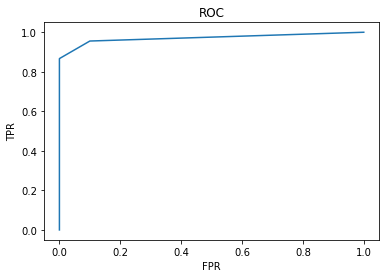

In [11]:
plot(predictions)

# A second method to compute the ROC curve by testing several threshold

[(0.0, 0.0), (0.044444444444444446, 0.9), (0.13333333333333333, 1.0), (1, 1)]
0.9711111111111111


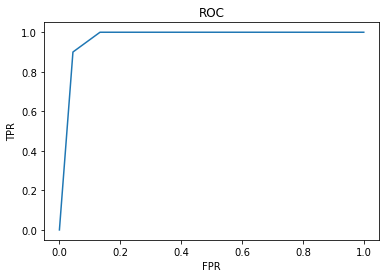

In [12]:
raw_points = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))).collect()

val = [(1,1)]

for th in range(1001):
    nbT=0.
    nbF=0.
    nbN=0.
    nbP=0.
    for (x,y) in raw_points:
        if x*1000. >= th:
            if y==1:
                nbT+=1
            else:
                nbF+=1
        if y==1:
            nbP+=1
        else:
            nbN+=1
    nv = (nbF/nbN,nbT/nbP)
    if nv!= val[-1]:
        val.append(nv)
    
val.reverse()
    
xs = [x for (x,y) in val]
ys = [y for (x,y) in val]
area = 0
for i in range(len(val)-1):
    area += (ys[i]+ys[i+1])*(xs[i+1]-xs[i])/2
print(val)
print(area)
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(xs, ys)

# Grid builder

In [13]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


paramGrid = ParamGridBuilder()\
    .addGrid(decisionTree.maxBins, [e*4 for e in range(4,16) ]) \
    .addGrid(decisionTree.maxDepth, [e for e in range(2,6) ]) \
    .build()

tvs = TrainValidationSplit(estimator=decisionTree,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

tvs_model = tvs.fit(train)
tvs_predictions = tvs_model.transform(test)
evaluator.evaluate(tvs_predictions)

0.9755555555555556

# Cross-validation

In [14]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator


paramGrid = ParamGridBuilder()\
    .addGrid(decisionTree.maxBins, range(4,16,4)) \
    .addGrid(decisionTree.maxDepth, range(3,8)) \
    .build()

cvs = CrossValidator(estimator=decisionTree,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    # 80% of the data will be used for training, 20% for validation.
                    numFolds=5)

cvs_model = cvs.fit(train)
cvs_predictions = cvs_model.transform(test)
evaluator.evaluate(cvs_predictions)

0.9681481481481482

# Show best model features

In [15]:
print(cvs_model.bestModel.toDebugString)
print(tvs_model.bestModel.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_6a0068338f00) of depth 6 with 45 nodes
  If (feature 1 <= 2.5)
   If (feature 5 <= 5.5)
    If (feature 0 <= 6.5)
     If (feature 7 <= 6.5)
      Predict: 0.0
     Else (feature 7 > 6.5)
      If (feature 0 <= 3.5)
       Predict: 0.0
      Else (feature 0 > 3.5)
       Predict: 1.0
    Else (feature 0 > 6.5)
     If (feature 2 <= 2.5)
      Predict: 0.0
     Else (feature 2 > 2.5)
      Predict: 1.0
   Else (feature 5 > 5.5)
    If (feature 0 <= 1.5)
     Predict: 0.0
    Else (feature 0 > 1.5)
     Predict: 1.0
  Else (feature 1 > 2.5)
   If (feature 1 <= 3.5)
    If (feature 5 <= 2.5)
     If (feature 7 <= 6.5)
      Predict: 0.0
     Else (feature 7 > 6.5)
      Predict: 1.0
    Else (feature 5 > 2.5)
     If (feature 0 <= 6.5)
      If (feature 7 <= 4.5)
       Predict: 1.0
      Else (feature 7 > 4.5)
       If (feature 7 <= 7.5)
        Predict: 0.0
       Else (feature 7 > 7.5)
        Predict: 1.0
     Else (feature 

Area Under ROC 0.9266666666666667
Area Under ROC 0.9755555555555557
Area Under ROC 0.9711111111111113


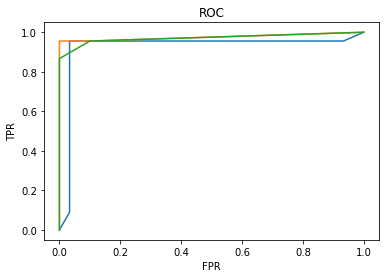

In [16]:
plot(cvs_predictions,tvs_predictions,predictions)
